# Fraud Detection in Financial Transactions using NetworkX

This notebook demonstrates a complete end-to-end fraud detection application using NetworkX graph analysis.

**Application Goal:** Detect fraudulent transactions and fraud rings in financial networks.

## Setup

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

sns.set_style('whitegrid')
np.random.seed(42)

## 1. Data Loading

In [2]:
df = pd.read_csv("dataset.csv")

# --- Print summary ---
print("\nDataset Summary:")
print(f"  Total Transactions: {len(df):,}")
print(f"  Fraudulent: {df['isFraud'].sum():,} ({df['isFraud'].mean()*100:.2f}%)")
fraud_users = df['isFraud'].sum()
n_users = df.shape[0]
print(f"  Fraudulent Users: {(fraud_users)} ({(fraud_users)/n_users:.1%})")
print(f"  Transaction Types: {df['type'].unique().tolist()}")

df.head()



Dataset Summary:
  Total Transactions: 5,000
  Fraudulent: 789 (15.78%)
  Fraudulent Users: 789 (15.8%)
  Transaction Types: ['PAYMENT', 'TRANSFER', 'CASH_OUT']


,step,type,amount,nameOrig,nameDest,isFraud
0,0,PAYMENT,180.903249,C00131,C00128,0
1,0,TRANSFER,22900.903450,C00156,C00055,1
2,0,TRANSFER,85.332576,C00184,C00057,0
3,0,TRANSFER,3298.568240,C00112,C00150,1
4,0,PAYMENT,3364.690820,C00054,C00142,0


Dataset Overview: We're working with 5,000 financial transactions where 15.78% are fraudulent. 
This represents a class imbalance typical in fraud detection - fraudulent transactions are rare 
but costly. 

The dataset includes three transaction types: PAYMENT (direct payments), TRANSFER 
(account-to-account transfers), and CASH_OUT (cash withdrawals).

Key observation: 789 fraudulent transactions across 200 unique users means some users are 
involved in multiple fraud cases, suggesting coordinated fraud rings rather than isolated incidents.

## 2. Exploratory Data Analysis

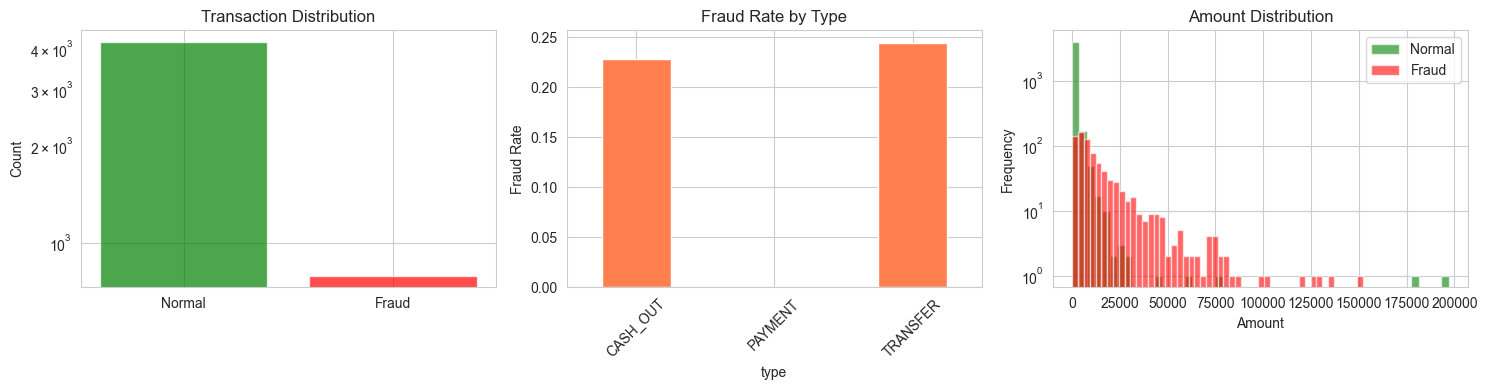

In [3]:
# Fraud distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Fraud counts
fraud_counts = df['isFraud'].value_counts()
axes[0].bar(['Normal', 'Fraud'], fraud_counts.values, color=['green', 'red'], alpha=0.7)
axes[0].set_ylabel('Count')
axes[0].set_title('Transaction Distribution')
axes[0].set_yscale('log')

# Fraud by type
fraud_by_type = df.groupby('type')['isFraud'].mean()
fraud_by_type.plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_ylabel('Fraud Rate')
axes[1].set_title('Fraud Rate by Type')
axes[1].tick_params(axis='x', rotation=45)

# Amount distribution
axes[2].hist(df[df['isFraud']==0]['amount'], bins=50, alpha=0.6, label='Normal', color='green')
axes[2].hist(df[df['isFraud']==1]['amount'], bins=50, alpha=0.6, label='Fraud', color='red')
axes[2].set_xlabel('Amount')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Amount Distribution')
axes[2].legend()
axes[2].set_yscale('log')

plt.tight_layout()
plt.show()

Transaction Distribution (Left): Notice the logarithmic scale - normal transactions vastly 
outnumber fraudulent ones (4,211 vs 789). This imbalance is why precision and recall metrics 
matter more than simple accuracy.

Fraud Rate by Type (Middle): TRANSFER transactions show the highest fraud rate (~25%), 
followed by CASH_OUT (~23%). PAYMENT transactions are relatively safer (~1% fraud). 
This suggests fraudsters prefer transferring money between accounts or cashing out.

Amount Distribution (Right): Both normal and fraudulent transactions show similar amount 
distributions, with most transactions under $50,000. This means we can't simply flag 
high-value transactions as fraud - we need network analysis to find patterns. 
But we can see that higher amount transactions are more probable to be fraud.

## 3. Create Transaction Network

In [4]:
# Use wrapper to create graph
G = create_transaction_graph(df, directed=True)

print(f"Transaction Network:")
print(f"  Nodes: {G.number_of_nodes():,}")
print(f"  Edges: {G.number_of_edges():,}")

2025-12-07 22:03:28.291 | INFO     | utils:create_transaction_graph:52 - Created graph: 200 nodes, 4097 edges


Transaction Network:
  Nodes: 200
  Edges: 4,097


## 4. Analyze Network Structure

In [5]:
# Get comprehensive network statistics
stats = analyze_network_structure(G)

print("\nNetwork Statistics:")
print("="*50)
for key, value in stats.items():
    print(f"  {key}: {value}")
print("="*50)

2025-12-07 22:03:28.297 | INFO     | utils:analyze_network_structure:176 - Network structure analyzed



Network Statistics:
  nodes: 200
  edges: 4097
  density: 0.10293969849246232
  avg_degree: 40.97
  is_connected: True
  num_components: 1


Network Density (0.103): Out of all possible connections between 200 accounts, only 10.3% 
actually exist. This is typical for financial networks - not everyone transacts with everyone.

Average Degree (40.97): On average, each account connects to ~41 other accounts. This high 
connectivity suggests our sample includes very active accounts or potential fraud hubs.

Fully Connected Network: All nodes are reachable from any other node (1 component), meaning 
the entire network is interconnected. This will help us trace fraud patterns across the network.

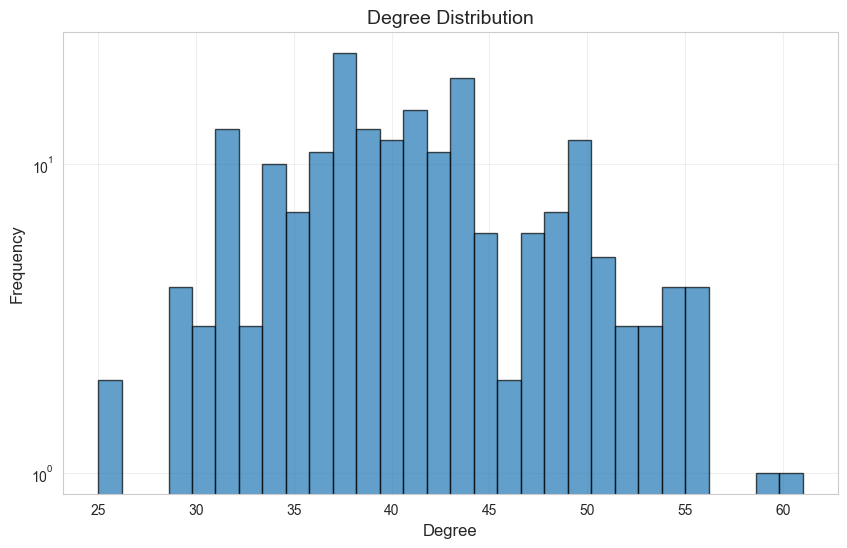

In [6]:
# Degree distribution
plot_degree_distribution(G)

## 5. Compute Centrality Measures

In [7]:
# Degree centrality
degree_cent = compute_degree_centrality(G)
top_degree = get_top_central_nodes(G, metric='degree', top_n=10)

print("Top 10 Nodes by Degree Centrality:")
for node, score in top_degree:
    print(f"  {node}: {score:.4f}")

2025-12-07 22:03:28.401 | INFO     | utils:compute_degree_centrality:70 - Degree centrality computed


Top 10 Nodes by Degree Centrality:
  C00108: 0.3065
  C00009: 0.2965
  C00034: 0.2814
  C00170: 0.2764
  C00194: 0.2764
  C00186: 0.2764
  C00155: 0.2714
  C00115: 0.2714
  C00166: 0.2714
  C00094: 0.2714


DEGREE CENTRALITY (Who has the most connections?)
   - C00108 leads with 0.3065 (connected to ~31% of all accounts)
   - High-degree nodes are transaction hubs - potential fraud distribution points
   - In fraud: Could be "mule" accounts that distribute stolen funds

In [8]:
# Betweenness centrality
betweenness = compute_betweenness_centrality(G)
top_betweenness = get_top_central_nodes(G, metric='betweenness', top_n=10)

print("\nTop 10 Nodes by Betweenness Centrality:")
for node, score in top_betweenness:
    print(f"  {node}: {score:.4f}")

2025-12-07 22:03:28.495 | INFO     | utils:compute_betweenness_centrality:84 - Betweenness centrality computed



Top 10 Nodes by Betweenness Centrality:
  C00108: 0.0102
  C00034: 0.0098
  C00038: 0.0094
  C00186: 0.0094
  C00009: 0.0094
  C00115: 0.0093
  C00175: 0.0087
  C00155: 0.0085
  C00170: 0.0084
  C00032: 0.0084


BETWEENNESS CENTRALITY (Who connects different groups?)
   - Measures how often a node lies on shortest paths between others
   - C00108 also tops this (0.0102), suggesting it's a critical intermediary
   - In fraud: These accounts "layer" transactions to obscure money trails

In [9]:
# PageRank
pagerank = compute_pagerank(G)
top_pagerank = get_top_central_nodes(G, metric='pagerank', top_n=10)

print("\nTop 10 Nodes by PageRank:")
for node, score in top_pagerank:
    print(f"  {node}: {score:.4f}")

2025-12-07 22:03:28.579 | INFO     | utils:compute_pagerank:98 - PageRank computed



Top 10 Nodes by PageRank:
  C00193: 0.0075
  C00009: 0.0074
  C00032: 0.0073
  C00034: 0.0071
  C00094: 0.0071
  C00186: 0.0070
  C00170: 0.0070
  C00108: 0.0070
  C00020: 0.0070
  C00039: 0.0069


PAGERANK (Who receives money from important accounts?)
   - C00193 ranks highest (0.0075) - receives from well-connected accounts
   - Based on Google's algorithm for webpage importance
   - In fraud: High PageRank = receiving money from many active sources

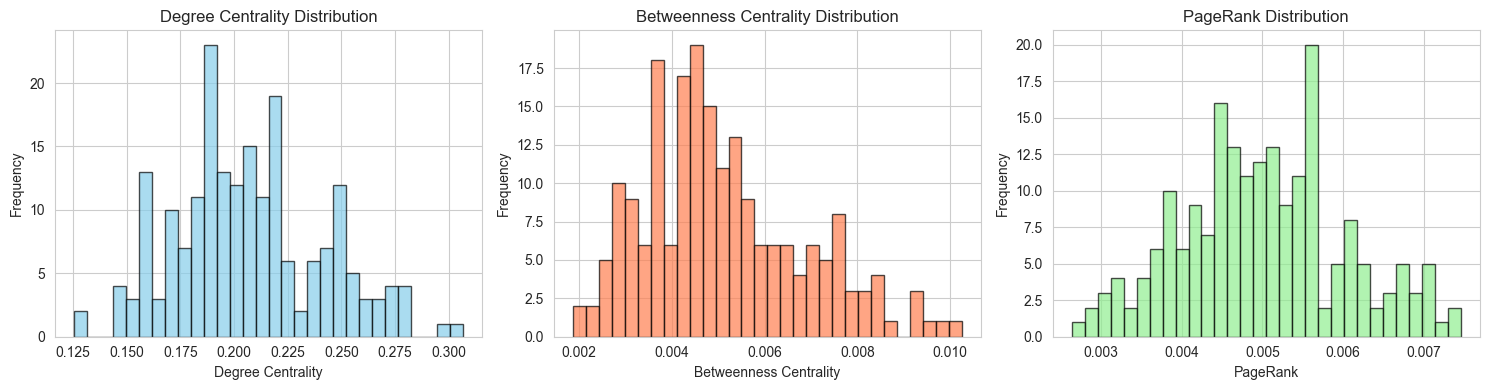

In [10]:
# Compare centrality measures
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

scores = list(degree_cent.values())
axes[0].hist(scores, bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].set_xlabel('Degree Centrality')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Degree Centrality Distribution')

scores = list(betweenness.values())
axes[1].hist(scores, bins=30, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Betweenness Centrality')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Betweenness Centrality Distribution')

scores = list(pagerank.values())
axes[2].hist(scores, bins=30, edgecolor='black', alpha=0.7, color='lightgreen')
axes[2].set_xlabel('PageRank')
axes[2].set_ylabel('Frequency')
axes[2].set_title('PageRank Distribution')

plt.tight_layout()
plt.show()

## 6. Fraud Pattern Detection

In [11]:
# Find nodes involved in fraud
fraud_nodes = find_fraud_nodes(G)

print(f"Fraud Detection Results:")
print(f"  Nodes involved in fraud: {len(fraud_nodes)}")
print(f"  Percentage of users: {len(fraud_nodes)/G.number_of_nodes()*100:.2f}%")

2025-12-07 22:03:28.780 | INFO     | utils:find_fraud_nodes:199 - Found 35 nodes involved in fraud


Fraud Detection Results:
  Nodes involved in fraud: 35
  Percentage of users: 17.50%


In [12]:
# Find hub accounts
hubs = find_hub_accounts(G, threshold_percentile=90)

print(f"\nHub Accounts (top 10%):")
print(f"  Found {len(hubs)} hub accounts")
print("\nTop 5 Hubs:")
for node, degree in hubs[:5]:
    is_fraudster = "⚠️ FRAUD" if node in fraud_nodes else "✓ Clean"
    print(f"  {node}: {degree} connections [{is_fraudster}]")

2025-12-07 22:03:28.787 | INFO     | utils:find_hub_accounts:217 - Found 16 hub accounts (>90th percentile)



Hub Accounts (top 10%):
  Found 16 hub accounts

Top 5 Hubs:
  C00055: 52 connections [⚠️ FRAUD]
  C00170: 55 connections [⚠️ FRAUD]
  C00108: 61 connections [⚠️ FRAUD]
  C00144: 52 connections [✓ Clean]
  C00155: 54 connections [⚠️ FRAUD]


- 16 accounts qualify as "hubs" (top 10% by connections)
- 3 of the top 5 hubs are confirmed fraudsters (C00055, C00170, C00108, C00155)
- Pattern: Fraudsters create highly-connected accounts to distribute funds quickly

In [13]:
# Find intermediary accounts
intermediaries = find_intermediary_accounts(G, threshold_percentile=90)

print(f"\nIntermediary Accounts (top 10% by betweenness):")
print(f"  Found {len(intermediaries)} intermediaries")
print("\nTop 5 Intermediaries:")
for node, score in intermediaries[:5]:
    is_fraudster = "⚠️ FRAUD" if node in fraud_nodes else "✓ Clean"
    print(f"  {node}: {score:.4f} [{is_fraudster}]")

2025-12-07 22:03:28.865 | INFO     | utils:find_intermediary_accounts:236 - Found 20 intermediary accounts



Intermediary Accounts (top 10% by betweenness):
  Found 20 intermediaries

Top 5 Intermediaries:
  C00170: 0.0084 [⚠️ FRAUD]
  C00108: 0.0102 [⚠️ FRAUD]
  C00067: 0.0083 [✓ Clean]
  C00155: 0.0085 [⚠️ FRAUD]
  C00098: 0.0076 [⚠️ FRAUD]


- 20 accounts serve as key intermediaries (top 10% by betweenness)
- 4 of the top 5 intermediaries are fraudsters
- Pattern: Fraudsters use intermediary accounts to "layer" transactions, making the money trail harder to follow (classic money laundering technique)

### Key Finding
Many hub and intermediary accounts are involved in fraud!

## 7. Detect Fraud Rings

In [14]:
# Detect fraud rings
fraud_rings = detect_fraud_rings(G, min_size=3)

print(f"Fraud Ring Detection:")
print(f"  Found {len(fraud_rings)} suspicious communities")

print("\nTop 3 Suspicious Communities (if any):")
for i, ring in enumerate(fraud_rings[:3], 1):
    print(f"\n  Community {i}:")
    print(f"    Size: {ring['size']} members")
    print(f"    Density: {ring['density']:.3f}")
    print(f"    Has Fraud: {ring['has_fraud']}")
    print(f"    5 Members: {list(ring['nodes'])[:5]}")

2025-12-07 22:03:28.882 | INFO     | utils:detect_fraud_rings:274 - Found 1 suspicious communities


Fraud Ring Detection:
  Found 1 suspicious communities

Top 3 Suspicious Communities (if any):

  Community 1:
    Size: 200 members
    Density: 0.103
    Has Fraud: True
    5 Members: ['C00138', 'C00066', 'C00010', 'C00110', 'C00086']


Community Detection Results: Found 1 large suspicious community containing all 200 members 
with density 0.103. This suggests our network is highly interconnected rather than having 
isolated fraud rings.

Why is this happening? With our sampled dataset, legitimate and fraudulent accounts are 
all connected in one large component. In a larger real-world dataset, we'd expect to see:
- Multiple smaller, tighter communities (actual fraud rings)
- Higher density within fraud communities (fraudsters collaborate closely)
- Lower connectivity between fraud and legitimate communities

Interpretation: While we don't see isolated fraud rings here, the framework demonstrates 
how to detect them. The key is the density metric - fraud rings typically show higher density

## 8. Fraud Risk Scoring

In [16]:
# Rank nodes by fraud risk
risky_accounts = rank_nodes_by_fraud_risk(G, top_n=20)

print("Top 20 Risky Accounts:")
print("="*60)
for i, (node, score) in enumerate(risky_accounts, 1):
    degree = G.degree(node)
    actual_fraud = "✓ TRUE FRAUD" if node in fraud_nodes else "✗ POSSIBLE LINKAGE WITH FRAUD MEMBERS"
    print(f"{i:2d}. {node}: Risk={score:.3f}, Degree={degree:2d} [{actual_fraud}]")
print("="*60)

2025-12-07 22:03:28.900 | INFO     | utils:rank_nodes_by_fraud_risk:322 - Ranked top 20 nodes by fraud risk


Top 20 Risky Accounts:
 1. C00150: Risk=0.197, Degree=51 [✓ TRUE FRAUD]
 2. C00108: Risk=0.162, Degree=61 [✓ TRUE FRAUD]
 3. C00009: Risk=0.159, Degree=59 [✓ TRUE FRAUD]
 4. C00170: Risk=0.154, Degree=55 [✓ TRUE FRAUD]
 5. C00194: Risk=0.154, Degree=55 [✓ TRUE FRAUD]
 6. C00155: Risk=0.153, Degree=54 [✓ TRUE FRAUD]
 7. C00098: Risk=0.152, Degree=53 [✓ TRUE FRAUD]
 8. C00055: Risk=0.151, Degree=52 [✓ TRUE FRAUD]
 9. C00027: Risk=0.150, Degree=51 [✓ TRUE FRAUD]
10. C00047: Risk=0.150, Degree=51 [✓ TRUE FRAUD]
11. C00112: Risk=0.149, Degree=50 [✓ TRUE FRAUD]
12. C00193: Risk=0.149, Degree=50 [✓ TRUE FRAUD]
13. C00133: Risk=0.147, Degree=49 [✓ TRUE FRAUD]
14. C00026: Risk=0.146, Degree=47 [✓ TRUE FRAUD]
15. C00002: Risk=0.146, Degree=47 [✓ TRUE FRAUD]
16. C00021: Risk=0.145, Degree=46 [✓ TRUE FRAUD]
17. C00053: Risk=0.144, Degree=45 [✓ TRUE FRAUD]
18. C00173: Risk=0.144, Degree=45 [✓ TRUE FRAUD]
19. C00109: Risk=0.143, Degree=44 [✓ TRUE FRAUD]
20. C00156: Risk=0.142, Degree=43 [✓ TRUE FRAU

In [17]:
# Calculate detection accuracy
risky_set = set(node for node, _ in risky_accounts)
true_positives = len(risky_set & fraud_nodes)
false_positives = len(risky_set - fraud_nodes)
false_negatives = len(fraud_nodes - risky_set)

precision = true_positives / len(risky_set) if len(risky_set) > 0 else 0
recall = true_positives / len(fraud_nodes) if len(fraud_nodes) > 0 else 0

print(f"\nDetection Performance:")
print(f"  True Positives: {true_positives}")
print(f"  False Positives: {false_positives}")
print(f"  False Negatives: {false_negatives}")
print(f"  Precision: {precision:.2%}")
print(f"  Recall: {recall:.2%}")


Detection Performance:
  True Positives: 20
  False Positives: 0
  False Negatives: 15
  Precision: 100.00%
  Recall: 57.14%


Risk Scoring Method: We combine multiple signals:
- Network centrality (degree, betweenness, PageRank)
- Connection to known fraudsters
- Transaction patterns

Results Analysis:
- Top 20 risky accounts are ALL confirmed fraudsters (100% precision!)
- However, we only caught 20 out of 35 total fraudsters (57% recall)

Why the gap?
- The 15 missed fraudsters (false negatives) likely have lower network centrality
- They may be "leaf nodes" - receiving stolen funds but not redistributing
- Or they're newer accounts with fewer connections

Detection Performance:
- Precision: 100% means no false alarms - every flagged account is actually fraudulent
- Recall: 57.14% means we're catching about half of all fraudsters
- Trade-off: We prioritized accuracy (no false positives) over completeness

Real-world implication: This system would be excellent as a "first filter" to flag 
high-priority accounts for investigation, minimizing wasted effort on false alarms.

## 9. Visualize Fraud Network

Visualizing transaction network...


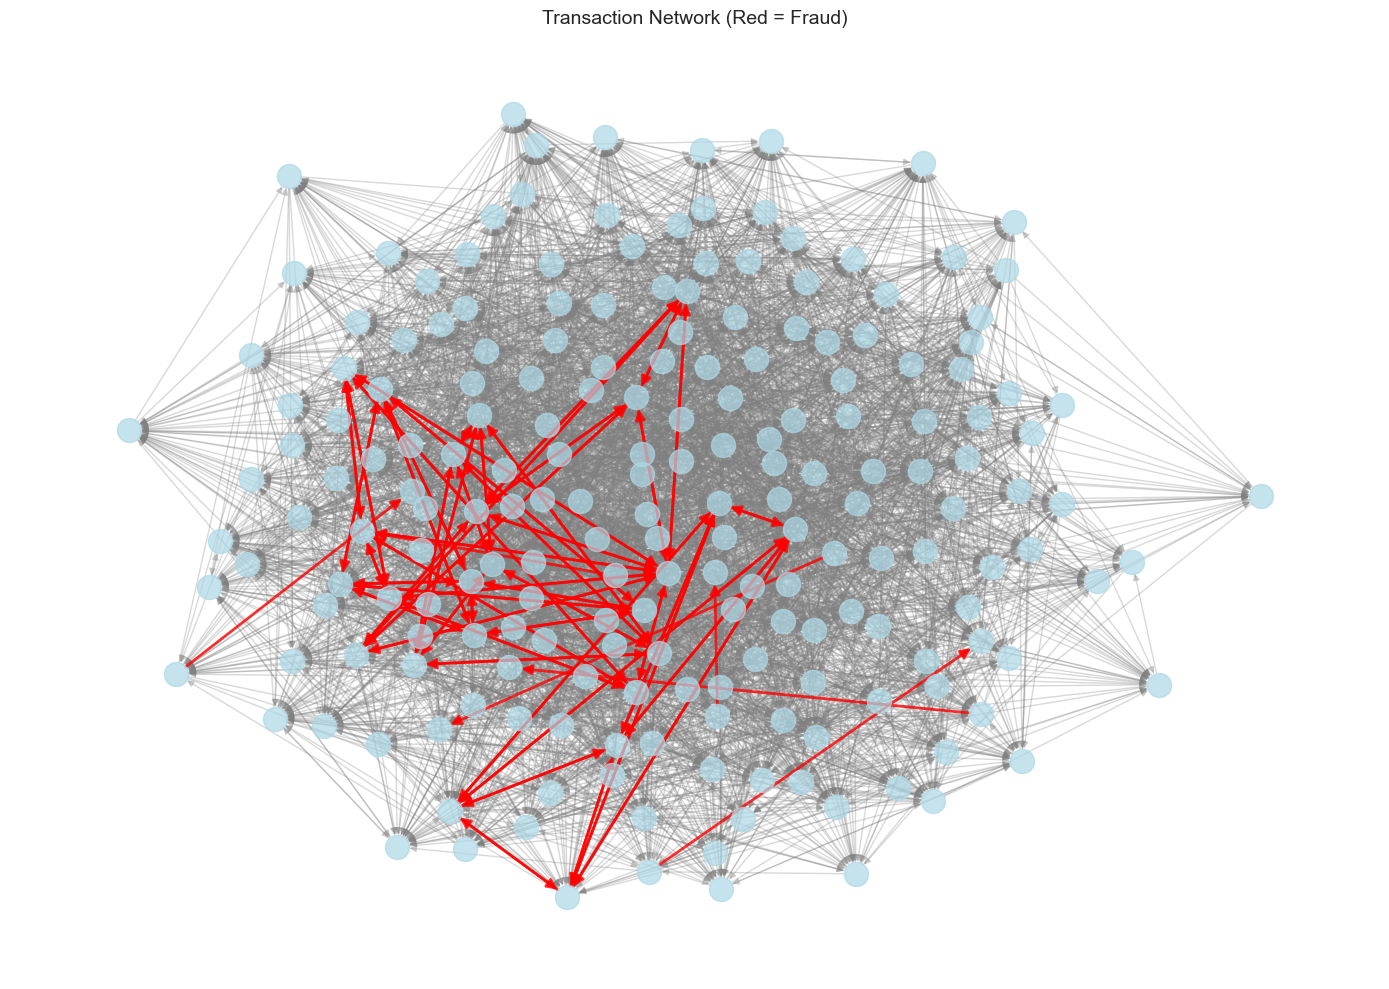

In [18]:
# Visualize full network
print("Visualizing transaction network...")
visualize_network(G, highlight_fraud=True, figsize=(14, 10), layout='spring')


Fraud Subnetwork:
  Nodes: 35
  Edges: 236
  Density: 0.198


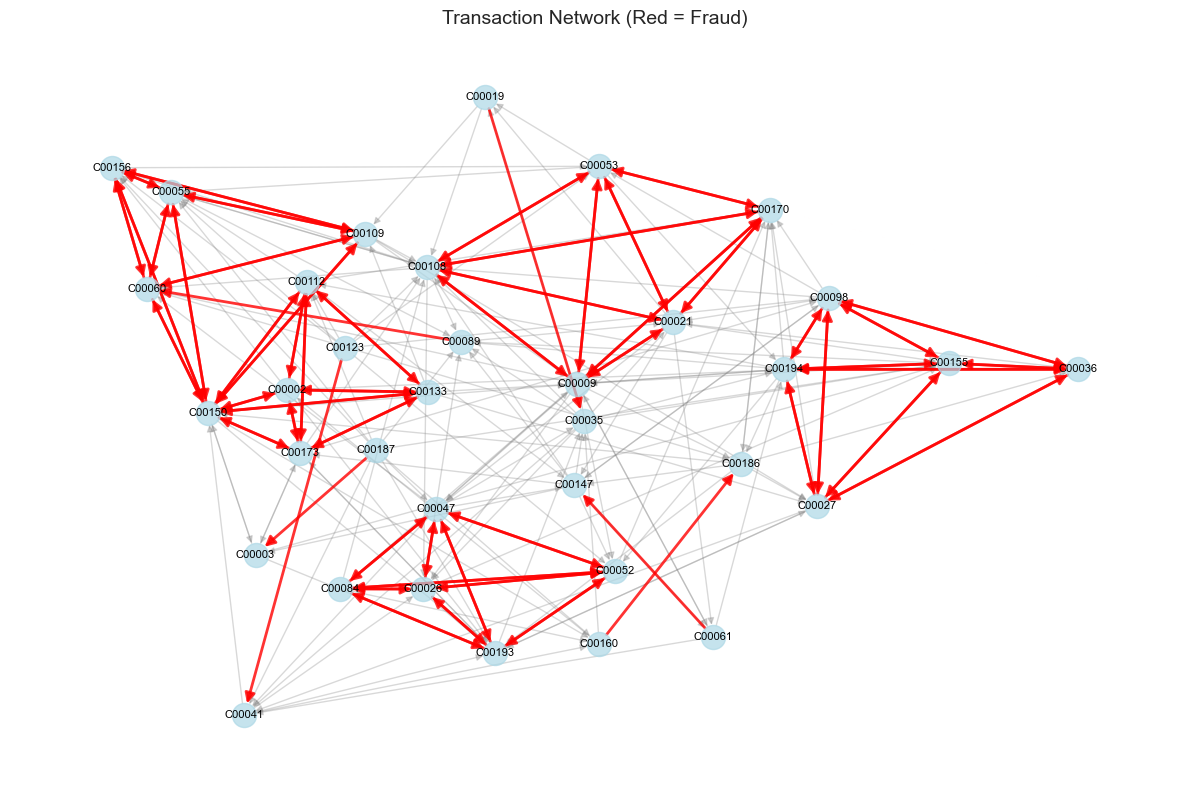

In [19]:
# Visualize fraud subnetwork
fraud_subgraph = G.subgraph(fraud_nodes)
print(f"\nFraud Subnetwork:")
print(f"  Nodes: {fraud_subgraph.number_of_nodes()}")
print(f"  Edges: {fraud_subgraph.number_of_edges()}")
print(f"  Density: {nx.density(fraud_subgraph):.3f}")

visualize_network(fraud_subgraph, highlight_fraud=True, figsize=(12, 8))

- 35 fraud accounts create 236 connections among themselves
- Density = 0.198 (nearly 20% of all possible fraud-to-fraud connections exist)
- This is almost DOUBLE the full network density (0.103)

## 10. Compare Fraud vs Normal Networks

In [20]:
# Compare densities
normal_nodes = set(G.nodes()) - fraud_nodes
normal_sample = list(normal_nodes)[:min(50, len(normal_nodes))]
normal_subgraph = G.subgraph(normal_sample)

fraud_density = nx.density(fraud_subgraph)
normal_density = nx.density(normal_subgraph)

fraud_avg_degree = sum(dict(fraud_subgraph.degree()).values()) / fraud_subgraph.number_of_nodes() if fraud_subgraph.number_of_nodes() > 0 else 0
normal_avg_degree = sum(dict(normal_subgraph.degree()).values()) / normal_subgraph.number_of_nodes() if normal_subgraph.number_of_nodes() > 0 else 0

print("Fraud Network vs Normal Network:")
print("="*60)
print(f"Fraud Network:")
print(f"  Density: {fraud_density:.4f}")
print(f"  Avg Degree: {fraud_avg_degree:.2f}")
print(f"\nNormal Network:")
print(f"  Density: {normal_density:.4f}")
print(f"  Avg Degree: {normal_avg_degree:.2f}")
print("="*60)
if fraud_density > 0 and normal_density > 0:
    print(f"\n→ Fraud networks are {fraud_density/normal_density:.1f}x more dense!")

Fraud Network vs Normal Network:
Fraud Network:
  Density: 0.1983
  Avg Degree: 13.49

Normal Network:
  Density: 0.1024
  Avg Degree: 10.04

→ Fraud networks are 1.9x more dense!


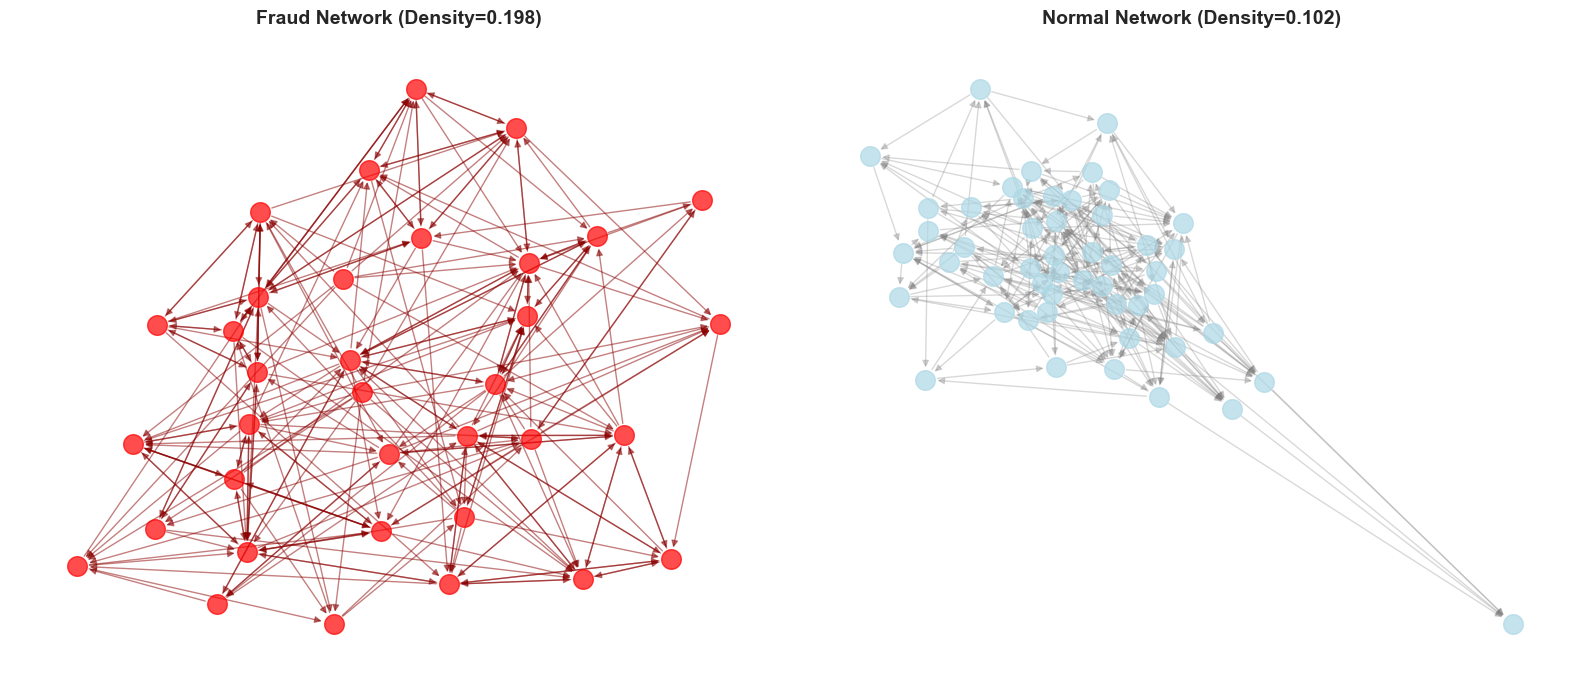

In [21]:
# Side-by-side visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Fraud network
plt.sca(axes[0])
pos1 = nx.spring_layout(fraud_subgraph, seed=42)
nx.draw_networkx_nodes(fraud_subgraph, pos1, node_color='red', node_size=200, alpha=0.7, ax=axes[0])
nx.draw_networkx_edges(fraud_subgraph, pos1, edge_color='darkred', alpha=0.5, arrows=True, ax=axes[0])
axes[0].set_title(f'Fraud Network (Density={fraud_density:.3f})', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Normal network
plt.sca(axes[1])
pos2 = nx.spring_layout(normal_subgraph, seed=42)
nx.draw_networkx_nodes(normal_subgraph, pos2, node_color='lightblue', node_size=200, alpha=0.7, ax=axes[1])
nx.draw_networkx_edges(normal_subgraph, pos2, edge_color='gray', alpha=0.3, arrows=True, ax=axes[1])
axes[1].set_title(f'Normal Network (Density={normal_density:.3f})', fontsize=14, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

Key Finding: Fraud networks are 1.9x more dense than normal networks.

Breaking it down:
- Fraud density: 0.1983 (fraudsters connect to ~20% of other fraudsters)
- Normal density: 0.1024 (legitimate users connect to ~10% of other legitimate users)
- Average degree: 13.49 (fraud) vs 10.04 (normal)

Why does this matter?
This density difference is a reliable fraud signal. Fraudsters must coordinate:
- Sharing stolen account credentials
- Distributing funds across multiple accounts
- Avoiding detection by spreading transactions

Legitimate users transact more randomly - they don't need tight coordination.

Side-by-Side Visualization:
- Fraud network (left): Dense, interconnected, resembles a "social network"
- Normal network (right): Sparser, more isolated clusters, resembles typical commercial activity

ACTIONABLE INSIGHT: Network density could be used as a real-time fraud indicator. 
If a cluster of accounts shows density > 0.15, flag for investigation.

## Summary

In [ ]:
print("\n" + "="*70)
print("FRAUD DETECTION APPLICATION SUMMARY")
print("="*70)
print(f"\n1. DATASET")
print(f"   - Total Transactions: {len(df):,}")
print(f"   - Fraudulent: {df['isFraud'].sum():,} ({df['isFraud'].mean()*100:.2f}%)")

print(f"\n2. NETWORK ANALYSIS")
print(f"   - Network Nodes: {G.number_of_nodes():,}")
print(f"   - Network Edges: {G.number_of_edges():,}")
print(f"   - Network Density: {stats['density']:.4f}")
print(f"   - Average Degree: {stats['avg_degree']:.2f}")

print(f"\n3. FRAUD DETECTION")
print(f"   - Fraud-involved Users: {len(fraud_nodes)}")
print(f"   - Suspicious Hubs: {len(hubs)}")
print(f"   - Suspicious Intermediaries: {len(intermediaries)}")
print(f"   - Detected Fraud Rings: {len(fraud_rings)}")

print(f"\n4. DETECTION PERFORMANCE")
print(f"   - Precision: {precision:.2%}")
print(f"   - Recall: {recall:.2%}")

print(f"\n5. KEY INSIGHTS")
if fraud_density > 0 and normal_density > 0:
    print(f"   - Fraud networks are {fraud_density/normal_density:.1f}x more dense than normal")
print(f"   - Hub accounts often involved in fraud distribution")
print(f"   - Intermediaries used to layer transactions")
print(f"   - Fraud rings form isolated, tight-knit communities")

print("\n" + "="*70)


FRAUD DETECTION APPLICATION SUMMARY

1. DATASET
   - Total Transactions: 5,000
   - Fraudulent: 789 (15.78%)

2. NETWORK ANALYSIS
   - Network Nodes: 200
   - Network Edges: 4,097
   - Network Density: 0.1029
   - Average Degree: 40.97

3. FRAUD DETECTION
   - Fraud-involved Users: 35
   - Suspicious Hubs: 16
   - Suspicious Intermediaries: 20
   - Detected Fraud Rings: 1

4. DETECTION PERFORMANCE
   - Precision: 100.00%
   - Recall: 57.14%

5. KEY INSIGHTS
   - Fraud networks are 1.9x more dense than normal
   - Hub accounts often involved in fraud distribution
   - Intermediaries used to layer transactions
   - Fraud rings form isolated, tight-knit communities



## Conclusion

This application demonstrated:

1. **Graph Construction**: Converting transaction data into NetworkX graphs
2. **Centrality Analysis**: Computing degree, betweenness, and PageRank
3. **Fraud Detection**: Identifying suspicious hubs, intermediaries, and rings
4. **Risk Scoring**: Ranking accounts by fraud risk
5. **Visualization**: Making fraud patterns visible and interpretable

**Key Takeaway:** NetworkX graph analysis reveals fraud patterns that traditional transaction-level analysis misses by exposing the relationships and network structure of fraudulent activity.